# Face Recognition

Lets discuss the steps of performing face recognition.
- Read images and get gray plane of the image using `opencv` tool.
- Detect faces in each image and get the cropped part using `haarcascaade-frontalface` detector.
- Performing face detection for each image in the training set and preparing the training data.
- Perform principal component analysis `PCA` and get the 5 dimensional representation for each face
- Inverse transform the data to get the representation of whole data using those top 5 eigen vectors.

Lets import all the required modules

In [80]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Now lets save our paths of training data, testing data and cascade file for face recognition.

In [81]:
training_path = "Data/Face_data/Training"
testing_path = "Data/Face_data/Testing"
harcascade_frontal_face_path = "Cascades/haarcascade_frontalface_alt.xml"

Now lets define a detect face function which takes input as the cv2 read image which in BGR format, coverts it into gray and finds the coordinates of face and returns the original image with facial coordinates.

In [82]:
def detect_face(img):
    """
    Method which perform face detection using haarcascade tool.
    img: cv2 BGR plane image
    returns: coordinated face of the given image, coordinates
    """
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    detector = cv2.CascadeClassifier(harcascade_frontal_face_path)
    faces = detector.detectMultiScale(gray_img, minNeighbors=3)
    if len(faces) == 0:
        return (-1, -1)
    (x, y, w, h) = faces[0]
    
    return (gray_img[y:y+w, x:x+h], faces[0])

## Preparing Training Faces

Now lets detect the faces for all our training data, images are in each folder for each person. So lets use os library in python to go through folders and read the images using open cv.

In [83]:
def prepare_data(path, type = "Training"):
    """
    Method which performs face detection task using detect face function for every image in the training set
    path: string where training image folders are present
    returns: detected faces and their labels(names of folders where group of images are present)
    """
    detected_faces = []
    face_labels = []
    img_dir = os.listdir(path)
    for dir_name in img_dir:
        label = str(dir_name)
        if not label.startswith("."):
            img_names = os.listdir(path + '/' + dir_name)
            for img_name in img_names:
                if not img_name.startswith("."):
                    img_path = path + '/' + dir_name + '/' + img_name
                    img = cv2.imread(img_path)
                    face, _ = detect_face(img)
                    resized_face = cv2.resize(face, (100, 100), interpolation = cv2.INTER_AREA)
                    p = "Build/Face_data" + '/' + type + '/' + label
                    if not os.path.exists(p):
                        os.makedirs(p)
                    cv2.imwrite(p + '/' + img_name, face)
                    detected_faces.append(resized_face)
                    face_labels.append(label)
    return (np.array(detected_faces), np.array(face_labels))

Lets write a small plot portraits function which prints all the faces with provided labels in a subplot manner using provided number of columns and number of rows.

In [84]:
def plot_portraits(images, titles, h, w, n_row, n_col):
    """
    Method which plots the array of images in a subplot manner
    images: array of image vectors
    title: image labels
    h: rows of image vector
    w: columns of image vector
    n_row: number of rows in subplot
    n_col: number of columns in subplot
    """
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap="gray")
        plt.title(titles[i], color="white")
        plt.xticks(())
        plt.yticks(())

In [85]:
faces, labels = prepare_data(training_path)
n_samples, h, w = faces.shape
# plot_portraits(faces, labels, h, w, n_row = 10, n_col = 10)

## Dimensionality reduction

Lets perform dimensionality reduction using PCA
1. Make the same image $N \times N$ on face image $I$.
2. Read each training face image, $I = (I_1, I_2, I_3,... I_i )$.
3. Change the dimensions of face image to vector size $1 \times N^2$ and symbolize each image $I_i$ as vector $\Gamma_i$.
4. Calculate the average matrix
$$\psi = \frac{1}{M}\sum_{i=1}^M\Gamma_i$$
5. Substract each face image matrix by its average
$$\phi = \Gamma_i - \psi$$
6. Calculating covariance matrix
$$C = \phi\phi^T$$
where
$$\phi = \begin{bmatrix}\phi_1\\ \phi_2\\ ..\\ \phi_M\end{bmatrix}$$
Because the size of the matris is too large, look for the covariance matrix be:
$$C = \phi^T\phi$$
7. Calculating eigenvalue and eigenvector
$$Cu_i = \lambda u_i$$
$$\text{Eigenvalue}(\lambda) = \text{Det}(C-\lambda I)$$
$$\text{Eigenvector}(u_i) = (C - \lambda I)u_i$$
8. Calculating eigenface ($\mu$)
$$\mu = \sum_{i=1}^Mv_iQ_i$$

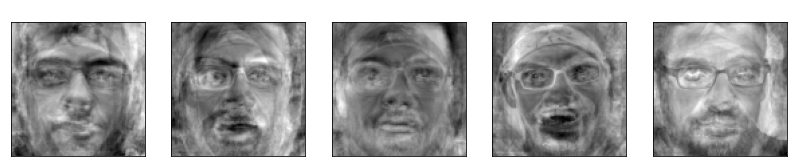

In [100]:
def pca(X, n_components):
    """
    Method which reduces the given data to 5 dimension format
    X: input data of faces
    returns:
    - components: top 5 eigen vectors
    - projection: projection of these eigenvectors into eigen space
    - mean: mean vector of input data
    - norm_data: normalised input data
    """
    mean = np.mean(X, 0)
    norm_data = X - mean
    cov = np.cov(X)
    eig_val, eig_vec = np.linalg.eig(cov)
    eig_val, eig_vec = zip(*sorted(zip(eig_val, eig_vec), reverse=True))
    eig_vec = np.array(eig_vec)
    components = eig_vec[:n_components]
    projection = np.matmul(components, norm_data)
    return (components.real, projection.real, mean, norm_data)

X = faces.reshape(n_samples, h*w)
C, P , M, N = pca(X, n_components=40)
eigenfaces = P.real
eigenface_titles = [f"eigenface {i+1}" for i in range(eigenfaces.shape[0])]
plot_portraits(eigenfaces, eigenface_titles, h, w, 1, 5)

In [101]:
training_data = pd.DataFrame(C.T)
training_data["labels"] = labels
X_train = training_data[[column for column in training_data.columns if column != "labels"]]
y_train = training_data["labels"]

## Inverse transformation of faces

To get the whole data use these 5 eigen faces and generate whole data using the mean vector by multiplying projections of top 5 principal components.

In [102]:
inverse_transform = np.matmul(C.T, P) + M
eigenfaces = inverse_transform
eigenface_titles = labels
# plot_portraits(eigenfaces, eigenface_titles, h, w, 10, 10)

## Preparing Test Data

In [103]:
faces, labels = prepare_data(testing_path, type="Testing")
n_samples, h, w = faces.shape
# plot_portraits(faces, labels, h, w, n_row = 3, n_col = 10)

In [104]:
def get_weight_vectors(X, principal_components, mean):
	norm_data = X - mean
	weight_vector = np.matmul(principal_components, norm_data.T)
	return (weight_vector)

In [105]:
X = faces.reshape(n_samples, h*w)
W = get_weight_vectors(X, P, M)
test_data = pd.DataFrame(W.T)
test_data["labels"] = labels
X_test = test_data[[column for column in test_data.columns if column != "labels"]]
y_test = test_data["labels"]

Since we got both training and test data in required 5 dimension format lets build a model to classify these.

## Modeling with 1-NN

In [109]:
import scipy.spatial

class KNN:
		def __init__(self, k):
				self.k = k
				
		def fit(self, X, y):
				self.X_train = X
				self.y_train = y
				
		def distance(self, X1, X2):
				distance = scipy.spatial.distance.euclidean(X1, X2)
				return distance
		
		def predict(self, X_test):
				final_output = []
				for i in range(len(X_test)):
						d = []
						outputs = []
						for j in range(len(X_train)):
								dist = self.distance(X_train.iloc[j] , X_test.iloc[i])
								d.append([dist, j])
						d.sort()
						d = d[0:self.k]
						for d, j in d:
								outputs.append(y_train.iloc[j])
						results = []
						ans = max(set(outputs), key = outputs.count)
						final_output.append(ans)
						
				return final_output
		
		def score(self, X_test, y_test):
				predictions = self.predict(X_test)
				return (predictions == y_test).sum() / len(y_test)



In [110]:
clf = KNN(k=1)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

1.0